In [19]:
import pandas as pd
from pyhive import hive
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import itertools

In [20]:
conn = hive.connect(
    host='hsrv01.pic.es',
    port='10000',
    database='cosmohub',
    auth='KERBEROS',
    kerberos_service_name='hive',
)

In [21]:
cursor = conn.cursor()

In [22]:
sql = """
USE msantama
"""

In [23]:
cursor.execute(sql)

In [24]:
sql = """
SELECT
  access_count
FROM study
WHERE action = 'remove'
"""

In [25]:
cursor.execute(sql)

In [26]:
df=pd.DataFrame(cursor.fetchall())

In [27]:
df = df[0]

In [41]:
# Here we substract one as the creations do not have to compute for the average, so access 0 is the creation of the file
df = df - 1

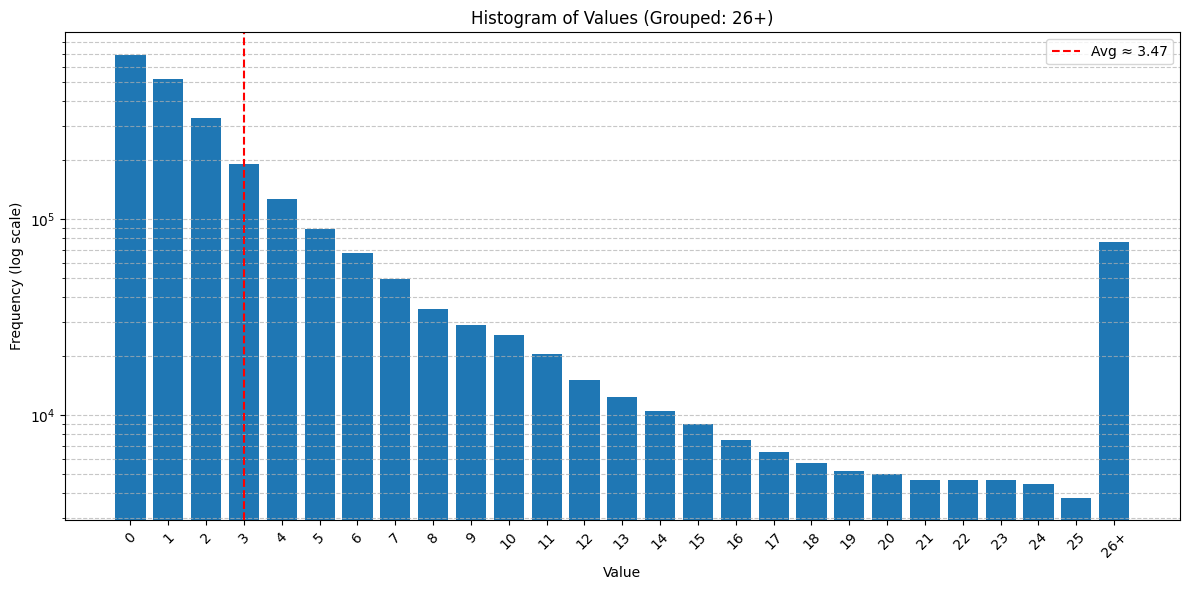

In [44]:
binned = df.copy()
binned = binned.apply(lambda x: '26+' if x > 25 else x)

# Count occurrences
counts = binned.value_counts().sort_index(
    key=lambda x: [int(i.rstrip('+')) if isinstance(i, str) else int(i) for i in x]
)

# Compute weighted average (ponderated)
weighted_sum = 0
total = 0
for k, v in counts.items():
    if isinstance(k, str) and k.endswith('+'):
        # Approximate with 26 as representative for "26+"
        val = 26
    else:
        val = int(k)
    weighted_sum += val * v
    total += v

weighted_avg = weighted_sum / total

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(counts.index.astype(str), counts.values)

# Add weighted average line
plt.axvline(x=str(int(weighted_avg)), color='red', linestyle='--', label=f'Avg ≈ {weighted_avg:.2f}')

# Log scale on y-axis
plt.yscale('log')

# Labels and title
plt.xlabel("Value")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Values (Grouped: 26+)")
plt.xticks(rotation=45)
plt.grid(True, which="both", axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
#TODO: action remove no i limitar les dates entre inici i fi de l'estudi (no tot l'historic)
sql = """
select UNIX_TIMESTAMP(access_date)-UNIX_TIMESTAMP(LAG(access_date) over (partition by pnfsid order by access_count)) as dt 
from study
"""

In [7]:
cursor.execute(sql)

In [8]:
df=pd.DataFrame(cursor.fetchall())
# Prepare data
days = df[0] / (3600 * 24)

In [9]:
del df

In [10]:
days

0                  NaN
1           255.311563
2                  NaN
3             0.092546
4           127.393843
               ...    
20423274           NaN
20423275      0.025567
20423276           NaN
20423277     66.515428
20423278     82.302905
Name: 0, Length: 20423279, dtype: float64

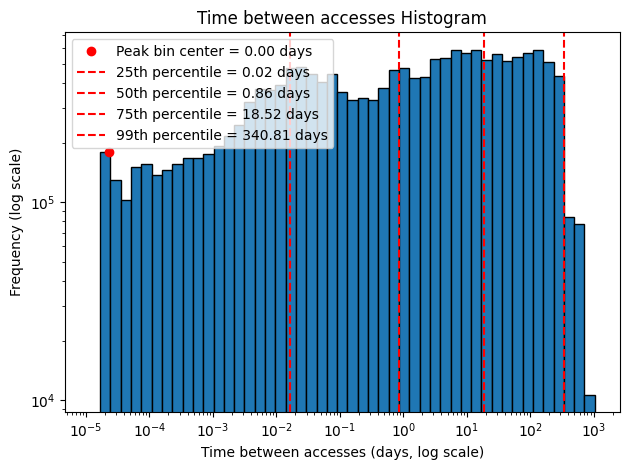

In [12]:
days = days.dropna()

days = days[days > 0.0000001]

# Percentiles
percentiles = [25, 50, 75, 99]
perc_values = [np.percentile(days, p) for p in percentiles]

# Logarithmic bins (coarse and fine)
bins_coarse = np.logspace(np.log10(days.min()), np.log10(days.max()), 50)
bins_fine = np.logspace(np.log10(days.min()), np.log10(days.max()), 500)

# Find fine histogram peak
counts_fine, edges_fine = np.histogram(days, bins=bins_fine)
max_idx = np.argmax(counts_fine)
peak_bin_center = (edges_fine[max_idx] + edges_fine[max_idx + 1]) / 2
peak_bin_count = counts_fine[max_idx]

# Plot coarse histogram
counts, bin_edges, _ = plt.hist(days, bins=bins_coarse, log=True, edgecolor='black')
plt.xscale('log')

# Estimate y-value for the fine peak in the coarse plot
# We'll find the coarse bin where the peak_bin_center falls
bin_index = np.digitize(peak_bin_center, bin_edges) - 1
bin_index = np.clip(bin_index, 0, len(counts)-1)
approx_y = counts[bin_index]

# Plot the fine peak point
plt.plot(peak_bin_center, approx_y, 'ro', label=f'Peak bin center = {peak_bin_center:.2f} days')

# Add percentile lines
for p, val in zip(percentiles, perc_values):
    plt.axvline(val, color='r', linestyle='--', label=f'{p}th percentile = {val:.2f} days')

# Finalize plot
plt.xlabel('Time between accesses (days, log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Time between accesses Histogram')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
#TODO: action remove no i limitar les dates entre inici i fi de l'estudi (no tot l'historic)
sql = """
select UNIX_TIMESTAMP(access_date) - UNIX_TIMESTAMP(creation_date)
from study
where action="remove"
"""

In [16]:
cursor.execute(sql)

In [17]:
df=pd.DataFrame(cursor.fetchall())
# Prepare data
days = df[0] / (3600 * 24)

In [18]:
del df

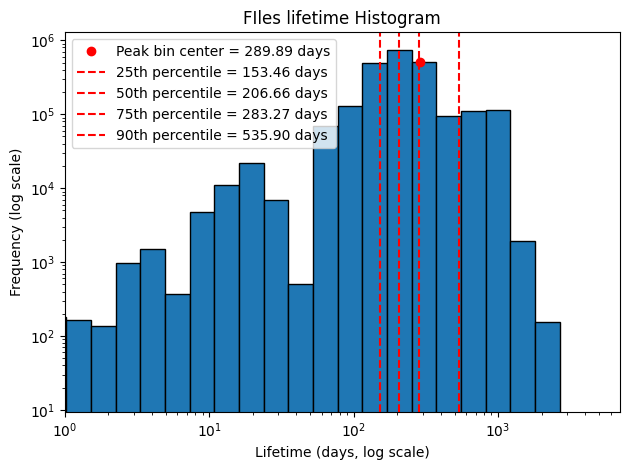

In [23]:
days = days.dropna()

days = days[days > 0.0000001]

# Percentiles
percentiles = [25, 50, 75, 90]
perc_values = [np.percentile(days, p) for p in percentiles]

# Logarithmic bins (coarse and fine)
bins_coarse = np.logspace(np.log10(days.min()), np.log10(days.max()), 50)
bins_fine = np.logspace(np.log10(days.min()), np.log10(days.max()), 500)

# Find fine histogram peak
counts_fine, edges_fine = np.histogram(days, bins=bins_fine)
max_idx = np.argmax(counts_fine)
peak_bin_center = (edges_fine[max_idx] + edges_fine[max_idx + 1]) / 2
peak_bin_count = counts_fine[max_idx]

# Plot coarse histogram
counts, bin_edges, _ = plt.hist(days, bins=bins_coarse, log=True, edgecolor='black')
plt.xscale('log')

# Estimate y-value for the fine peak in the coarse plot
# We'll find the coarse bin where the peak_bin_center falls
bin_index = np.digitize(peak_bin_center, bin_edges) - 1
bin_index = np.clip(bin_index, 0, len(counts)-1)
approx_y = counts[bin_index]

# Plot the fine peak point
plt.plot(peak_bin_center, approx_y, 'ro', label=f'Peak bin center = {peak_bin_center:.2f} days')

# Add percentile lines
for p, val in zip(percentiles, perc_values):
    plt.axvline(val, color='r', linestyle='--', label=f'{p}th percentile = {val:.2f} days')


plt.xlim(left=1)
# Finalize plot
plt.xlabel('Lifetime (days, log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('FIles lifetime Histogram')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
#TODO: action remove no i limitar les dates entre inici i fi de l'estudi (no tot l'historic)
sql = """
select UNIX_TIMESTAMP(access_date) - UNIX_TIMESTAMP(creation_date)
from study
where action="request"
and access_count=1
"""

In [25]:
cursor.execute(sql)

In [26]:
df=pd.DataFrame(cursor.fetchall())
# Prepare data
days = df[0] / (3600 * 24)

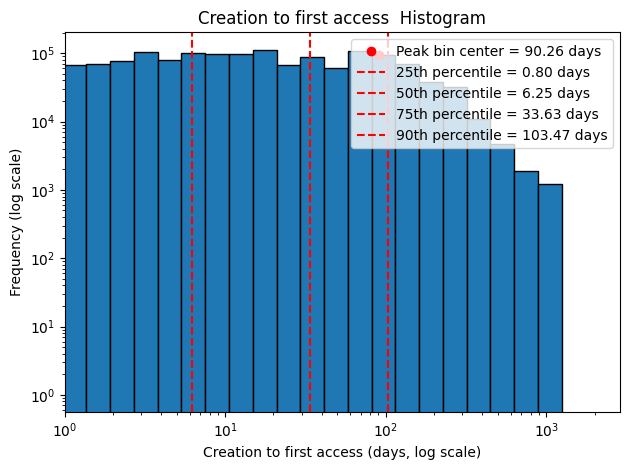

In [27]:
days = days.dropna()

days = days[days > 0.0000001]

# Percentiles
percentiles = [25, 50, 75, 90]
perc_values = [np.percentile(days, p) for p in percentiles]

# Logarithmic bins (coarse and fine)
bins_coarse = np.logspace(np.log10(days.min()), np.log10(days.max()), 50)
bins_fine = np.logspace(np.log10(days.min()), np.log10(days.max()), 500)

# Find fine histogram peak
counts_fine, edges_fine = np.histogram(days, bins=bins_fine)
max_idx = np.argmax(counts_fine)
peak_bin_center = (edges_fine[max_idx] + edges_fine[max_idx + 1]) / 2
peak_bin_count = counts_fine[max_idx]

# Plot coarse histogram
counts, bin_edges, _ = plt.hist(days, bins=bins_coarse, log=True, edgecolor='black')
plt.xscale('log')

# Estimate y-value for the fine peak in the coarse plot
# We'll find the coarse bin where the peak_bin_center falls
bin_index = np.digitize(peak_bin_center, bin_edges) - 1
bin_index = np.clip(bin_index, 0, len(counts)-1)
approx_y = counts[bin_index]

# Plot the fine peak point
plt.plot(peak_bin_center, approx_y, 'ro', label=f'Peak bin center = {peak_bin_center:.2f} days')

# Add percentile lines
for p, val in zip(percentiles, perc_values):
    plt.axvline(val, color='r', linestyle='--', label=f'{p}th percentile = {val:.2f} days')


plt.xlim(left=1)
# Finalize plot
plt.xlabel('Creation to first access (days, log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Creation to first access  Histogram')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
sql = """
WITH all_events AS (
  SELECT
    action,
    access_date,
    LAG(access_date) OVER (PARTITION BY pnfsid ORDER BY access_count) AS prev_access_date,
    LAG(action) OVER (PARTITION BY pnfsid ORDER BY access_count) AS prev_action
  FROM study
)

SELECT
  UNIX_TIMESTAMP(access_date) - UNIX_TIMESTAMP(prev_access_date) AS seconds_since_last_request
FROM all_events
WHERE action = 'remove'
  AND prev_action = 'request'

"""

In [41]:
cursor.execute(sql)

In [42]:
df=pd.DataFrame(cursor.fetchall())
# Prepare data
days = df[0] / (3600 * 24)

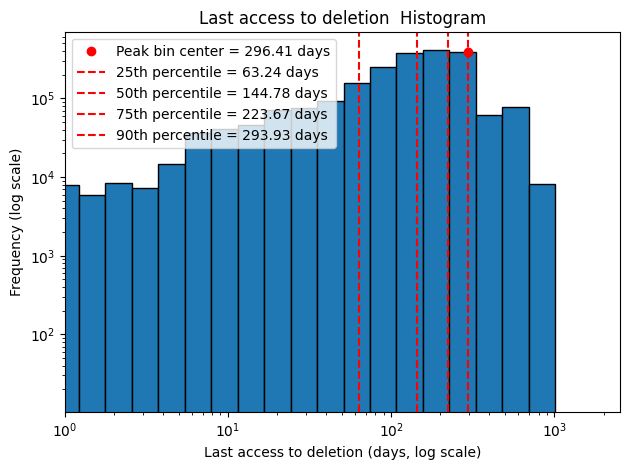

In [43]:
days = days.dropna()

days = days[days > 0.0000001]

# Percentiles
percentiles = [25, 50, 75, 90]
perc_values = [np.percentile(days, p) for p in percentiles]

# Logarithmic bins (coarse and fine)
bins_coarse = np.logspace(np.log10(days.min()), np.log10(days.max()), 50)
bins_fine = np.logspace(np.log10(days.min()), np.log10(days.max()), 500)

# Find fine histogram peak
counts_fine, edges_fine = np.histogram(days, bins=bins_fine)
max_idx = np.argmax(counts_fine)
peak_bin_center = (edges_fine[max_idx] + edges_fine[max_idx + 1]) / 2
peak_bin_count = counts_fine[max_idx]

# Plot coarse histogram
counts, bin_edges, _ = plt.hist(days, bins=bins_coarse, log=True, edgecolor='black')
plt.xscale('log')

# Estimate y-value for the fine peak in the coarse plot
# We'll find the coarse bin where the peak_bin_center falls
bin_index = np.digitize(peak_bin_center, bin_edges) - 1
bin_index = np.clip(bin_index, 0, len(counts)-1)
approx_y = counts[bin_index]

# Plot the fine peak point
plt.plot(peak_bin_center, approx_y, 'ro', label=f'Peak bin center = {peak_bin_center:.2f} days')

# Add percentile lines
for p, val in zip(percentiles, perc_values):
    plt.axvline(val, color='r', linestyle='--', label=f'{p}th percentile = {val:.2f} days')


plt.xlim(left=1)
# Finalize plot
plt.xlabel('Last access to deletion (days, log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Last access to deletion  Histogram')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
sql = """
select access_date, pnfsid, action 
from study
"""

In [7]:
cursor.execute(sql)

In [8]:
df = pd.DataFrame(cursor.fetchall())

In [9]:
df.columns = ['access_date', 'pnfsid', 'action']
df['access_date'] = pd.to_datetime(df['access_date'])  # convert to datetime

In [10]:
df

,access_date,pnfsid,action
0,2021-06-08 02:44:59,0000000000CA60444F3FB69DD6381DEDFA7C,request
1,2021-06-08 06:40:10,0000000000CA60444F3FB69DD6381DEDFA7C,request
2,2021-10-01 10:27:20,0000000000CA60444F3FB69DD6381DEDFA7C,request
3,2021-10-03 01:11:59,0000000000CA60444F3FB69DD6381DEDFA7C,request
4,2021-10-03 15:23:15,0000000000CA60444F3FB69DD6381DEDFA7C,request
...,...,...,...
20423274,2023-05-21 12:00:28,00004740ED9C8AF348F2B0C10BBA287CEAB9,request
20423275,2023-05-21 12:01:14,00004740ED9C8AF348F2B0C10BBA287CEAB9,request
20423276,2023-05-29 16:34:14,00004740ED9C8AF348F2B0C10BBA287CEAB9,request
20423277,2023-05-29 17:30:15,00004740ED9C8AF348F2B0C10BBA287CEAB9,request


In [11]:
# # Get unique pnfsids
# unique_pnfsids = df['pnfsid'].unique()
# np.random.seed(42)  # for reproducibility

# # Take a 5% random sample
# sample_size = int(len(unique_pnfsids) * 0.05)
# sampled_pnfsids = np.random.choice(unique_pnfsids, size=sample_size, replace=False)

# # Filter the original df
# df_sampled = df[df['pnfsid'].isin(sampled_pnfsids)]

In [12]:
# --- Preprocess once ---
print("Starting")
df.sort_values('access_date', inplace=True)
df['date'] = df['access_date'].dt.floor('D')  # daily granularity
total_unique_files = df['pnfsid'].nunique()

# --- Pre-bucket data by date ---
buckets = defaultdict(lambda: {'remove': set(), 'access': set()})
for row in df.itertuples(index=False):
    date = row.date
    if row.action == 'remove':
        buckets[date]['remove'].add(row.pnfsid)
    else:
        buckets[date]['access'].add(row.pnfsid)

all_dates = sorted(buckets.keys())

# --- Window parameters ---
observation_windows_days = [0.1, 0.5, 1, 3, 7, 15, 21, 28, 35, 42, 49, 56, 63, 70, 85, 100, 150, 200, 300]
prediction_windows_days = [7, 10, 15, 20, 30, 50, 75]
start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2024-01-01")

# --- Results storage ---
results = []

print("Preprocessing complete: Starint loop")
# --- Iterate over window combinations ---
for obs_days in observation_windows_days:
    print(f"Processing obs window: {obs_days} days")
    for pred_days in prediction_windows_days:
        print(f"  Prediction window: {pred_days} days")
        observation_window = timedelta(days=obs_days)
        prediction_window = timedelta(days=pred_days)

        current_date = start_date + observation_window
        total_hits = 0
        total_active = 0
        y_ratios = []

        while current_date + prediction_window <= end_date:
            obs_start = current_date - observation_window
            pred_end = current_date + prediction_window

            # Get date ranges
            obs_dates = pd.date_range(obs_start.normalize(), current_date.normalize() - timedelta(seconds=1), freq='D')
            pred_dates = pd.date_range(current_date.normalize(), pred_end.normalize() - timedelta(seconds=1), freq='D')

            # Active files in observation period
            accessed_files = set()
            removed_files = set()
            for d in obs_dates:
                accessed_files |= buckets[d]['access']
                removed_files |= buckets[d]['remove']
            active_files = accessed_files - removed_files

            # Hits in prediction window
            hits = set()
            for d in pred_dates:
                hits |= buckets[d]['access']

            true_hits = active_files & hits
            n_active = len(active_files)
            n_hits = len(true_hits)

            if n_active > 0:
                y_ratios.append(n_hits / n_active)
                total_hits += n_hits
                total_active += n_active

            current_date += prediction_window

        if total_active > 0:
            results.append({
                "observation_days": obs_days,
                "prediction_days": pred_days,
                "weighted_y_percentage": total_hits / total_active,
                "mean_y_percentage": np.mean(y_ratios),
                "std_y_percentage": np.std(y_ratios),
                "n_periods": len(y_ratios),
                "total_files_seen": total_active,
                "coverage_percentage": total_active / total_unique_files * 100,
                "total_hits": total_hits,
            })

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results)


Starting
Preprocessing complete: Starint loop
Processing obs window: 0.1 days
  Prediction window: 7 days
  Prediction window: 10 days
  Prediction window: 15 days
  Prediction window: 20 days
  Prediction window: 30 days
  Prediction window: 50 days
  Prediction window: 75 days
Processing obs window: 0.5 days
  Prediction window: 7 days
  Prediction window: 10 days
  Prediction window: 15 days
  Prediction window: 20 days
  Prediction window: 30 days
  Prediction window: 50 days
  Prediction window: 75 days
Processing obs window: 1 days
  Prediction window: 7 days
  Prediction window: 10 days
  Prediction window: 15 days
  Prediction window: 20 days
  Prediction window: 30 days
  Prediction window: 50 days
  Prediction window: 75 days
Processing obs window: 3 days
  Prediction window: 7 days
  Prediction window: 10 days
  Prediction window: 15 days
  Prediction window: 20 days
  Prediction window: 30 days
  Prediction window: 50 days
  Prediction window: 75 days
Processing obs window:

In [13]:
# Convert the results dataframe to CSV and save it
results_df.to_csv('window_analysis_results.csv', index=False)
print(f"Results saved to 'window_analysis_results.csv'")

Results saved to 'window_analysis_results.csv'


In [2]:
results_df = pd.read_csv('window_analysis_results.csv')

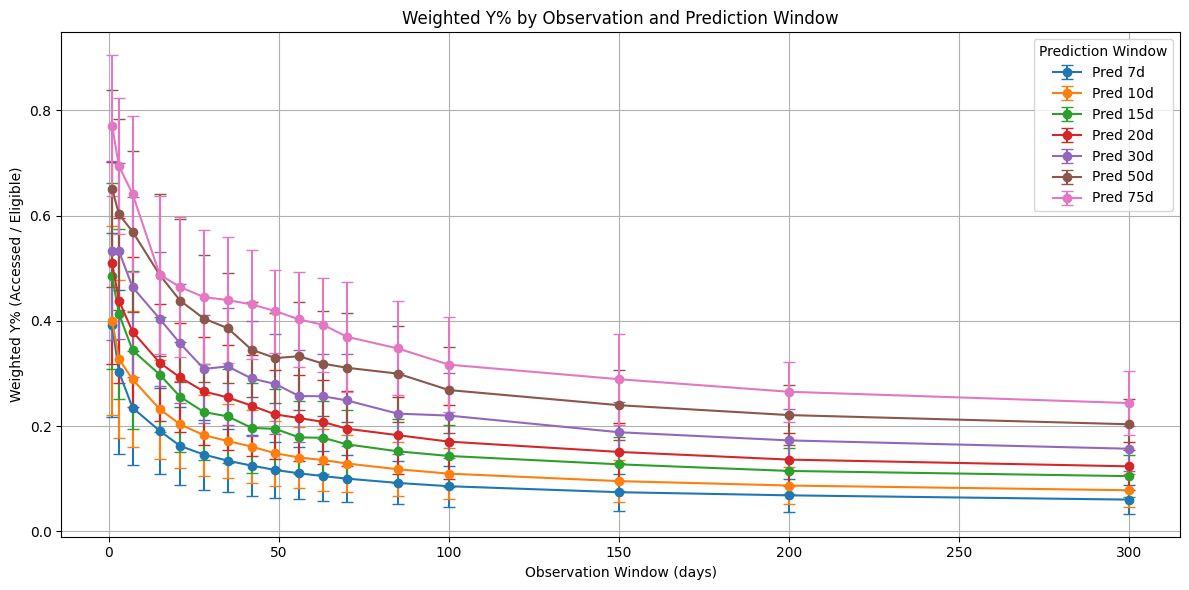

In [3]:
# --- Plotting ---
plt.figure(figsize=(12, 6))
for pred_days in sorted(results_df['prediction_days'].unique()):
    subset = results_df[results_df['prediction_days'] == pred_days]
    plt.errorbar(
        subset['observation_days'],
        subset['weighted_y_percentage'],
        yerr=subset['std_y_percentage'],
        label=f'Pred {pred_days}d',
        capsize=4,
        marker='o'
    )

plt.xlabel('Observation Window (days)')
plt.ylabel('Weighted Y% (Accessed / Eligible)')
plt.title('Weighted Y% by Observation and Prediction Window')
plt.legend(title="Prediction Window")
plt.grid(True)
plt.tight_layout()
plt.savefig("weighted_y_plot_optimized.png")
plt.show()

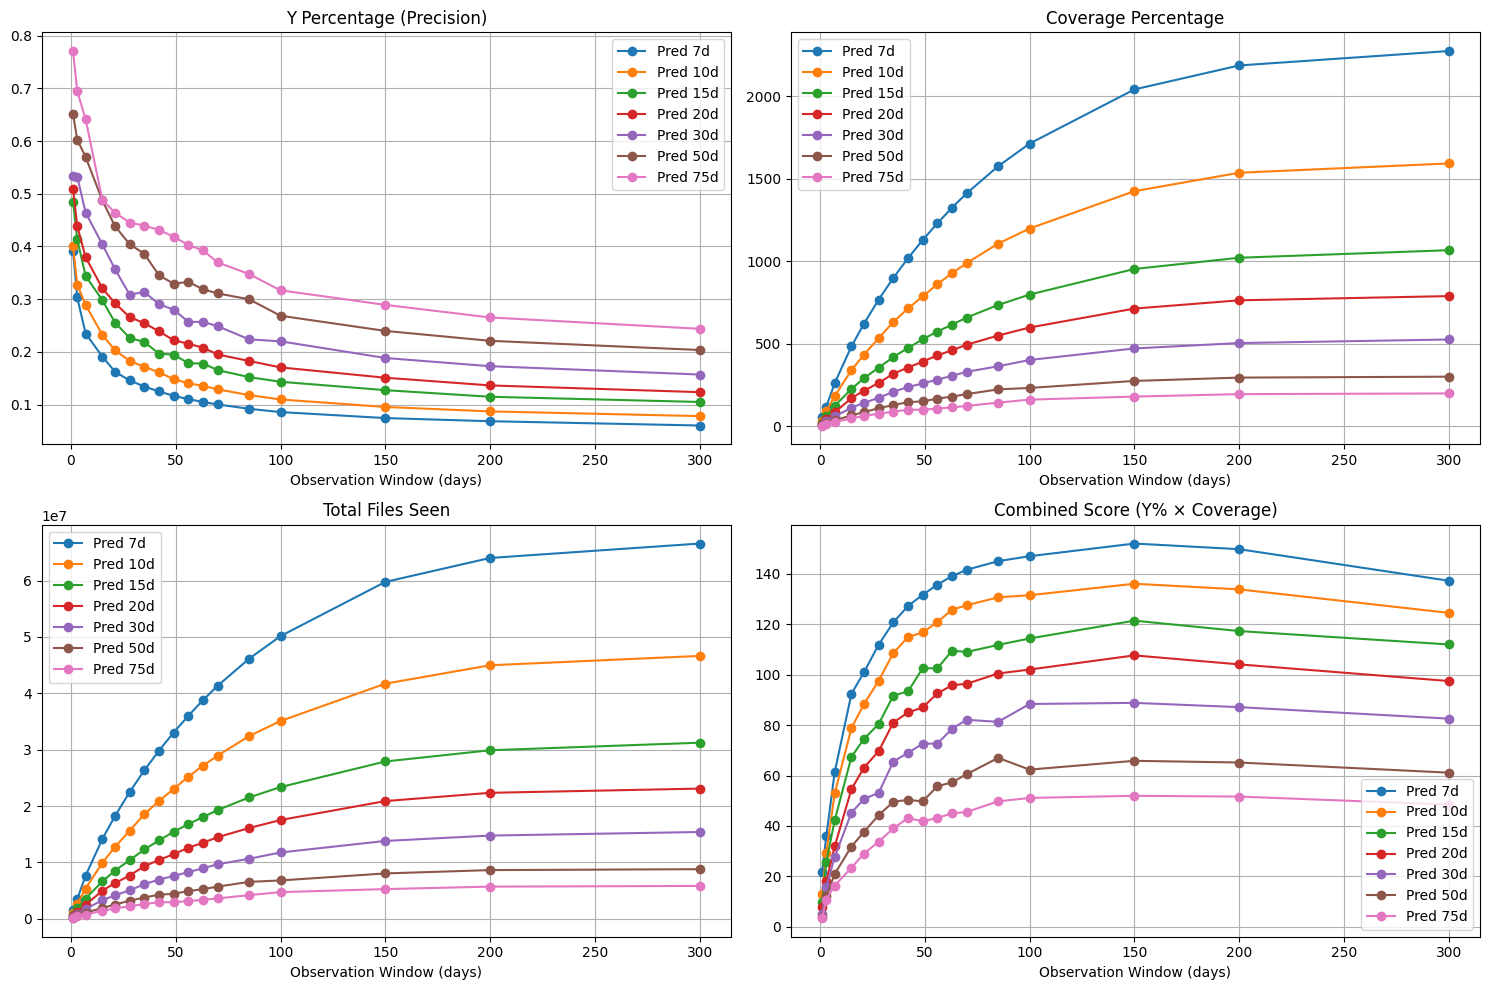

In [4]:
# Create subplot with multiple metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for pred_days in sorted(results_df['prediction_days'].unique()):
    subset = results_df[results_df['prediction_days'] == pred_days]
    
    # Plot 1: Y percentage (your current plot)
    axes[0,0].plot(subset['observation_days'], subset['weighted_y_percentage'], 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 2: Coverage percentage  
    axes[0,1].plot(subset['observation_days'], subset['coverage_percentage'], 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 3: Total files seen (absolute numbers)
    axes[1,0].plot(subset['observation_days'], subset['total_files_seen'], 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 4: Combined score (y% * coverage)
    combined_score = subset['weighted_y_percentage'] * subset['coverage_percentage'] 
    axes[1,1].plot(subset['observation_days'], combined_score, 
                   label=f'Pred {pred_days}d', marker='o')

axes[0,0].set_title('Y Percentage (Precision)')
axes[0,1].set_title('Coverage Percentage')  
axes[1,0].set_title('Total Files Seen')
axes[1,1].set_title('Combined Score (Y% × Coverage)')

for ax in axes.flat:
    ax.set_xlabel('Observation Window (days)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [5]:
results_df

,observation_days,prediction_days,weighted_y_percentage,mean_y_percentage,std_y_percentage,n_periods,total_files_seen,coverage_percentage,total_hits
0,1,7,0.391728,0.386931,0.174485,156,1620440,55.370468,634772
1,1,10,0.400520,0.389607,0.179984,109,947641,32.380912,379549
2,1,15,0.485166,0.466558,0.176080,72,596342,20.377018,289325
3,1,20,0.509691,0.479591,0.192381,54,457452,15.631144,233159
4,1,30,0.532999,0.516976,0.170256,36,284357,9.716485,151562
...,...,...,...,...,...,...,...,...,...
114,300,15,0.104999,0.100343,0.040367,53,31228401,1067.075101,3278945
115,300,20,0.123626,0.119030,0.045768,39,23086933,788.880973,2854143
116,300,30,0.157076,0.149436,0.042274,26,15388892,525.838754,2417223
117,300,50,0.203570,0.195903,0.048921,15,8791943,300.420872,1789778


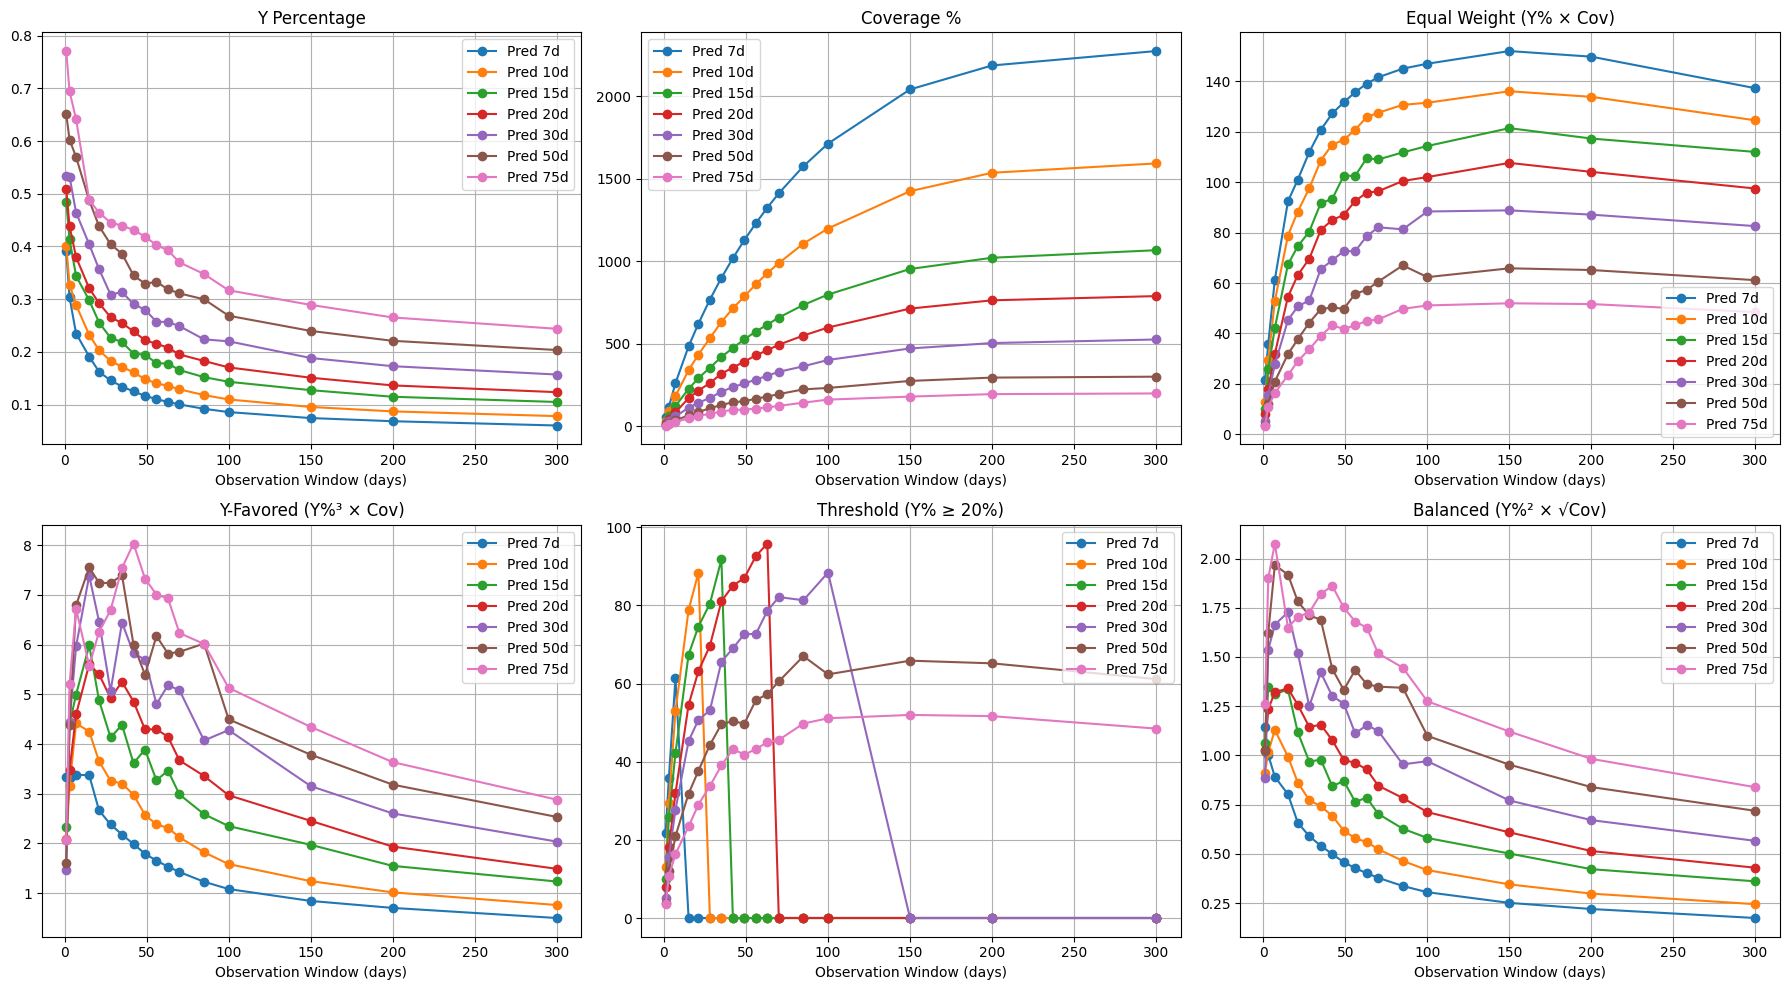

In [6]:
# Create a comprehensive scoring comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for pred_days in sorted(results_df['prediction_days'].unique()):
    subset = results_df[results_df['prediction_days'] == pred_days]
    
    # Plot 1: Y percentage
    axes[0,0].plot(subset['observation_days'], subset['weighted_y_percentage'], 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 2: Coverage percentage  
    axes[0,1].plot(subset['observation_days'], subset['coverage_percentage'], 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 3: Equal weight (original)
    equal_score = subset['weighted_y_percentage'] * subset['coverage_percentage']
    axes[0,2].plot(subset['observation_days'], equal_score, 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 4: Y-favored score (Y%^3 * Coverage)
    y_favored_score = (subset['weighted_y_percentage']**3) * subset['coverage_percentage']
    axes[1,0].plot(subset['observation_days'], y_favored_score, 
                   label=f'Pred {pred_days}d', marker='o')
    
    # Plot 5: High threshold score (Y% > 5%)
    min_threshold = 0.2
    valid_mask = subset['weighted_y_percentage'] >= min_threshold
    threshold_score = np.where(valid_mask, 
                              subset['weighted_y_percentage'] * subset['coverage_percentage'], 
                              0)
    axes[1,1].plot(subset['observation_days'], threshold_score, 
                   label=f'Pred {pred_days}d', marker='o')

    # Plot 6: Balanced score with weights
    balanced_score = (subset['weighted_y_percentage']**2) * np.sqrt(subset['coverage_percentage'])
    axes[1,2].plot(subset['observation_days'], balanced_score, 
                   label=f'Pred {pred_days}d', marker='o')

titles = ['Y Percentage', 'Coverage %', 'Equal Weight (Y% × Cov)',
         'Y-Favored (Y%³ × Cov)', f'Threshold (Y% ≥ {min_threshold*100:.0f}%)', 'Balanced (Y%² × √Cov)']

for ax, title in zip(axes.flat, titles):
    ax.set_title(title)
    ax.set_xlabel('Observation Window (days)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Curve flattens at x ≈ 81.87, CDF ≈ 0.94


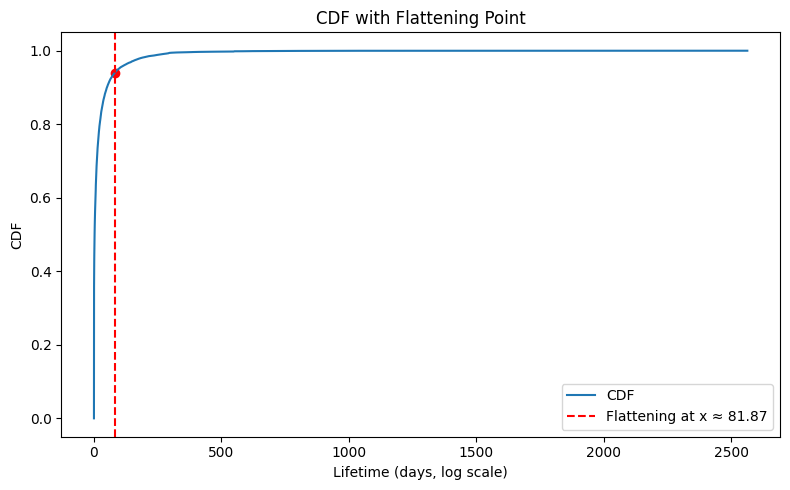

In [20]:
# Find all indices after start_x where the slope drops below the threshold
threshold = 0.0001  # Define a threshold for slope
candidate_idxs = np.where(mask & (slope < threshold))[0]

# Skip if the first candidate is at index 0 (i.e., x=0)
if len(candidate_idxs) > 0:
    # Find the first candidate that is not at the very start
    for idx in candidate_idxs:
        if sorted_days[idx] > start_x:
            flatten_idx = idx
            flatten_x = sorted_days[flatten_idx]
            flatten_y = cdf[flatten_idx]
            print(f"Curve flattens at x ≈ {flatten_x:.2f}, CDF ≈ {flatten_y:.2f}")
            break
    else:
        print("No flattening point found after start_x.")
else:
    print("No flattening point found.")

plt.figure(figsize=(8, 5))
plt.plot(sorted_days, cdf, label='CDF')
plt.axvline(flatten_x, color='r', linestyle='--', label=f'Flattening at x ≈ {flatten_x:.2f}')
plt.scatter(flatten_x, flatten_y, color='red')
plt.xlabel('Lifetime (days)')
plt.ylabel('CDF')
plt.title('CDF with Flattening Point')
plt.legend()
plt.tight_layout()
plt.show()
